# Make Figure 3C

This notebook makes Figure 3C. It also shows how we calculated the number of trans proteins significant in only one cancer, the total number of trans genes, and the most significant gene. 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import re
import sys 
import statsmodels.stats.multitest

import cptac

/Users/Lindsey/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Step 1: Load data and calculate std dev and mean for p values and correaltions

In [2]:
df_fdr_pvals = pd.read_csv("Make_Tables/csv_files/Supplemental_Table_2.csv")
df_fdr_pvals = df_fdr_pvals.set_index("Comparison")
df_fdr_pvals

,Correlation_GBM,P_value_GBM,Correlation_ccRCC,P_value_ccRCC,Correlation_OV,P_value_OV,Correlation_LUAD,P_value_LUAD,Correlation_LSCC,P_value_LSCC,Correlation_BR,P_value_BR,Correlation_CO,P_value_CO,Correlation_HNSCC,P_value_HNSCC
Comparison,,,,,,,,,,,,,,,,
PHLDA1,0.816848,3.507071e-21,0.254436,0.060261,NaN,NaN,0.260110,0.074530,0.713420,2.644826e-14,0.364797,0.002164,0.386104,0.122847,0.587915,1.282608e-08
GRB2,-0.610889,6.729990e-08,-0.217427,0.120342,-0.190090,0.346111,-0.302439,0.020631,-0.198042,2.437176e-01,-0.177379,0.142733,0.150960,0.347409,-0.496325,1.084446e-05
SOCS2,0.562720,3.420388e-06,NaN,NaN,NaN,NaN,NaN,NaN,0.472624,1.417921e-02,NaN,NaN,NaN,NaN,-0.014519,9.611234e-01
CDH4,0.559180,3.420388e-06,0.148407,0.513490,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DAB2,-0.556402,3.420388e-06,-0.076173,0.673774,0.076981,0.750510,-0.086403,0.597546,-0.072496,7.501117e-01,0.326055,0.003543,-0.147519,0.360266,-0.224967,7.751436e-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PIM1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.002105,9.917500e-01
HEPHL1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.001563,9.931644e-01
SULT6B1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.001236,9.950909e-01


In [3]:
#Calculate mean and standard deviation for pvalues and Pearson Correlations
df_fdr_pvals["Standard_Deviation_P_value"] = df_fdr_pvals.loc[:,["P_value_GBM","P_value_ccRCC","P_value_OV","P_value_BR","P_value_LUAD","P_value_HNSCC","P_value_LSCC","P_value_CO"]].std(axis = 1)
df_fdr_pvals["Mean_P_value"] = df_fdr_pvals.loc[:,["P_value_GBM","P_value_ccRCC","P_value_OV","P_value_BR","P_value_LUAD","P_value_HNSCC","P_value_LSCC","P_value_CO"]].mean(axis = 1)
df_fdr_pvals["Standard_Deviation_Correlation"] = (df_fdr_pvals.loc[:,["Correlation_GBM","Correlation_ccRCC","Correlation_OV","Correlation_BR","Correlation_LUAD","Correlation_HNSCC","Correlation_LSCC","Correlation_CO"]].std(axis = 1))
df_fdr_pvals["Mean_Correlation"] = (df_fdr_pvals.loc[:,["Correlation_GBM","Correlation_ccRCC","Correlation_OV","Correlation_BR","Correlation_LUAD","Correlation_HNSCC","Correlation_LSCC","Correlation_CO"]].mean(axis = 1))


# Step 2: Calculate the number of significant cancers for each protein

In [4]:
def Pvalue_sig(row):
    numSig = 0

    for item in row:
        if pd.isnull(item):
            continue
        if item < 0.05:
            numSig += 1
            
    return numSig

In [5]:
df_fdr_pvals["Num_sig"] = df_fdr_pvals.loc[:,["P_value_GBM","P_value_ccRCC","P_value_OV","P_value_BR","P_value_LUAD","P_value_HNSCC","P_value_LSCC","P_value_CO"]].apply(Pvalue_sig, axis = 1)
df_fdr_pvals = df_fdr_pvals.sort_values(by=['Num_sig'],ascending=False)

In [6]:
#Filter for proteins that are significant in at least 1 cancer. 
df_fdr_pvals_1 = df_fdr_pvals[df_fdr_pvals['Num_sig'].isin([1,2,3,4,5,6,7,8])]
df_fdr_pvals_1

,Correlation_GBM,P_value_GBM,Correlation_ccRCC,P_value_ccRCC,Correlation_OV,P_value_OV,Correlation_LUAD,P_value_LUAD,Correlation_LSCC,P_value_LSCC,...,P_value_BR,Correlation_CO,P_value_CO,Correlation_HNSCC,P_value_HNSCC,Standard_Deviation_P_value,Mean_P_value,Standard_Deviation_Correlation,Mean_Correlation,Num_sig
Comparison,,,,,,,,,,,,,,,,,,,,,
CD109,-0.361839,0.004379,0.268902,0.044632,0.015377,0.961793,0.113339,4.717738e-01,0.360461,7.836561e-03,...,2.042875e-02,0.297635,0.042193,0.454761,6.489557e-05,0.348542,0.194138,0.256942,0.176748,6
LANCL2,0.478723,0.000091,0.188217,0.193598,0.110983,0.627956,0.588808,4.733914e-08,0.575817,2.040789e-07,...,7.599309e-03,0.320786,0.026823,0.802151,2.402226e-23,0.220706,0.107008,0.231603,0.420808,6
MYO10,0.447478,0.000289,-0.263921,0.049045,0.374118,0.035041,0.230896,8.949836e-02,0.292466,4.901629e-02,...,5.191477e-07,NaN,NaN,0.434632,1.438282e-04,0.034009,0.031862,0.262712,0.290210,6
KIF13B,-0.143903,0.357780,-0.310972,0.016103,0.439778,0.009101,-0.272975,3.960258e-02,-0.363670,6.920009e-03,...,5.460232e-03,0.019902,0.918920,-0.461065,5.405157e-05,0.326292,0.169243,0.288168,-0.175657,6
CNNM4,-0.372324,0.003168,0.069926,0.718877,0.076606,0.751602,0.270616,4.101591e-02,0.311652,3.142153e-02,...,2.329196e-02,0.352937,0.013936,0.334353,4.724641e-03,0.331640,0.198505,0.279528,0.097964,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
FOCAD,-0.222947,0.118042,-0.156409,0.301258,0.136961,0.529834,-0.043120,8.167967e-01,-0.119464,5.514336e-01,...,3.467651e-02,-0.038724,0.844439,-0.129688,3.632494e-01,0.297350,0.444966,0.157445,-0.041136,1
RP9,0.267494,0.050019,0.281464,0.038103,-0.034538,0.902588,0.142091,3.654801e-01,-0.124529,5.276900e-01,...,9.484806e-02,0.181217,0.425821,-0.135184,3.654298e-01,0.291649,0.346247,0.170241,0.097105,1
SPRYD4,-0.154349,0.317228,-0.107842,0.517131,0.022701,0.937347,-0.261441,4.980613e-02,0.084696,7.023310e-01,...,1.559846e-01,-0.188732,0.222575,0.144480,2.974645e-01,0.298781,0.399983,0.145208,-0.079081,1


In [7]:
df_fdr_pvals_2 = df_fdr_pvals[df_fdr_pvals['Num_sig'].isin([2,3,4,5,6,7,8])]
df_fdr_pvals_2.sort_values('Standard_Deviation_Correlation', ascending = False)

,Correlation_GBM,P_value_GBM,Correlation_ccRCC,P_value_ccRCC,Correlation_OV,P_value_OV,Correlation_LUAD,P_value_LUAD,Correlation_LSCC,P_value_LSCC,...,P_value_BR,Correlation_CO,P_value_CO,Correlation_HNSCC,P_value_HNSCC,Standard_Deviation_P_value,Mean_P_value,Standard_Deviation_Correlation,Mean_Correlation,Num_sig
Comparison,,,,,,,,,,,,,,,,,,,,,
AADAT,-0.309262,0.036663,-0.500150,0.016817,NaN,NaN,0.234834,0.359704,NaN,NaN,...,0.000123,NaN,NaN,NaN,NaN,0.171569,0.103327,0.485593,-0.005223,3
RAD54B,NaN,NaN,NaN,NaN,0.341356,0.257334,NaN,NaN,-0.440955,0.043781,...,0.007540,NaN,NaN,NaN,NaN,0.134978,0.102885,0.484369,0.115135,2
BLK,NaN,NaN,NaN,NaN,-0.206703,0.323508,-0.365512,0.008767,NaN,NaN,...,0.495538,NaN,NaN,0.619337,0.002076,0.243665,0.207472,0.433368,0.034550,2
MYO6_1,NaN,NaN,NaN,NaN,0.284469,0.123849,0.328788,0.010495,NaN,NaN,...,0.000098,NaN,NaN,NaN,NaN,0.068643,0.044814,0.418986,0.065066,2
CCDC158,NaN,NaN,NaN,NaN,NaN,NaN,0.321006,0.102793,0.463473,0.011273,...,NaN,NaN,NaN,-0.303368,0.025244,0.049303,0.046437,0.407878,0.160370,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BCAP29,0.242843,0.082042,0.190517,0.354042,0.187454,0.355738,0.247327,0.065703,0.304235,0.038550,...,0.390483,0.182904,0.248474,0.262668,0.033445,0.156866,0.196060,0.059891,0.216203,2
BANK1,NaN,NaN,NaN,NaN,NaN,NaN,-0.319113,0.018246,-0.280041,0.063422,...,NaN,NaN,NaN,-0.392125,0.014143,0.027344,0.031937,0.056892,-0.330426,2
NECTIN4,NaN,NaN,NaN,NaN,0.193696,0.335659,0.305474,0.019128,0.266301,0.083113,...,0.043933,NaN,NaN,0.219732,0.085915,0.127264,0.113550,0.043251,0.243977,2


# Calculate the number of proteins significant in only one cancer

The manuscript mentions that 4,152/ 6,501 proteins are significant in only one cancer. This code block derives those numbers 

In [8]:
#print the number of genes significant in 1, 2, 3 ect cancers
counts = df_fdr_pvals_1['Num_sig'].value_counts()
counts

1    4152
2    1666
3     506
4     148
5      24
6       5
Name: Num_sig, dtype: int64

In [9]:
print("Total number of trans genes " + str(len(df_fdr_pvals_1)))

Total number of trans genes 6501


# Most consistent gene

This code block show the genes that are significant in 6 cancers. LANCL2 is the only one that doesn't have opposite trans effects in different cancers

In [10]:
df_fdr_pvals_6 = df_fdr_pvals[df_fdr_pvals['Num_sig'].isin([6])]
df_fdr_pvals_6

,Correlation_GBM,P_value_GBM,Correlation_ccRCC,P_value_ccRCC,Correlation_OV,P_value_OV,Correlation_LUAD,P_value_LUAD,Correlation_LSCC,P_value_LSCC,...,P_value_BR,Correlation_CO,P_value_CO,Correlation_HNSCC,P_value_HNSCC,Standard_Deviation_P_value,Mean_P_value,Standard_Deviation_Correlation,Mean_Correlation,Num_sig
Comparison,,,,,,,,,,,,,,,,,,,,,
CD109,-0.361839,0.004379,0.268902,0.044632,0.015377,0.961793,0.113339,4.717738e-01,0.360461,7.836561e-03,...,2.042875e-02,0.297635,0.042193,0.454761,6.489557e-05,0.348542,0.194138,0.256942,0.176748,6
LANCL2,0.478723,0.000091,0.188217,0.193598,0.110983,0.627956,0.588808,4.733914e-08,0.575817,2.040789e-07,...,7.599309e-03,0.320786,0.026823,0.802151,2.402226e-23,0.220706,0.107008,0.231603,0.420808,6
MYO10,0.447478,0.000289,-0.263921,0.049045,0.374118,0.035041,0.230896,8.949836e-02,0.292466,4.901629e-02,...,5.191477e-07,NaN,NaN,0.434632,1.438282e-04,0.034009,0.031862,0.262712,0.290210,6
KIF13B,-0.143903,0.357780,-0.310972,0.016103,0.439778,0.009101,-0.272975,3.960258e-02,-0.363670,6.920009e-03,...,5.460232e-03,0.019902,0.918920,-0.461065,5.405157e-05,0.326292,0.169243,0.288168,-0.175657,6
CNNM4,-0.372324,0.003168,0.069926,0.718877,0.076606,0.751602,0.270616,4.101591e-02,0.311652,3.142153e-02,...,2.329196e-02,0.352937,0.013936,0.334353,4.724641e-03,0.331640,0.198505,0.279528,0.097964,6


# Drop proteins that don't have data for atleast 6 out of 8 cancers 


In [11]:
df_fdr_pvals_1_subset = df_fdr_pvals_1.dropna(thresh = 17)


# Step 2: Make Figure 3 C

/Users/Lindsey/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


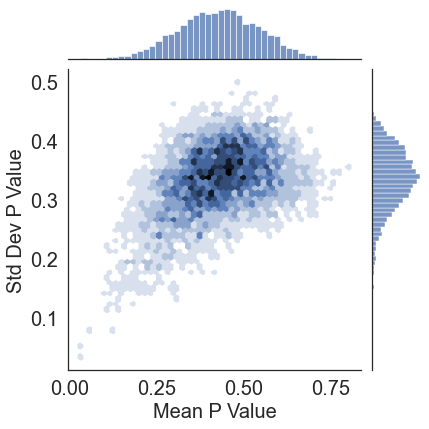

In [12]:

sns.set(rc={'xtick.labelsize':20,
            'ytick.labelsize':20}, style = "white")
g = (sns.jointplot("Mean_P_value","Standard_Deviation_P_value",data = df_fdr_pvals_1_subset, kind="hex", bins = 10)
        .set_axis_labels("Mean P Value", "Std Dev P Value", fontsize=20))

plt.show()
g.savefig("png_files/Figure3C_Pvalue.png", dpi = 300)

/Users/Lindsey/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


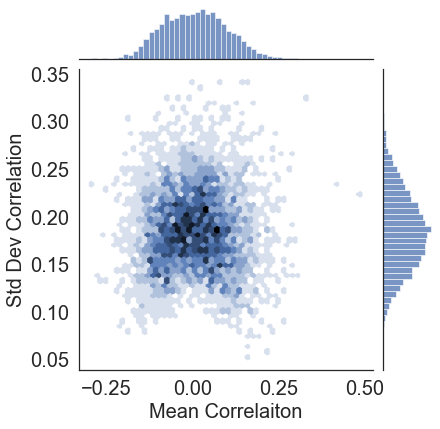

In [13]:
sns.set(rc={'xtick.labelsize':20,
            'ytick.labelsize':20}, style = "white")

g = (sns.jointplot("Mean_Correlation","Standard_Deviation_Correlation",data = df_fdr_pvals_1_subset, kind="hex", bins = 10)
        .set_axis_labels("Mean Correlaiton", "Std Dev Correlation", fontsize=20))


g.savefig("png_files/Figure3C_Corr.png", dpi = 300)
plt.show()

The following figures are supplemental and show the graphs restricted to proteins significant in at least 2 or 3 cancers. 

# Filter for genes significant in at least 2 Cancers 

In [14]:

df_fdr_pvals_2 = df_fdr_pvals[df_fdr_pvals['Num_sig'].isin([2,3,4,5,6,7,8])]

/Users/Lindsey/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


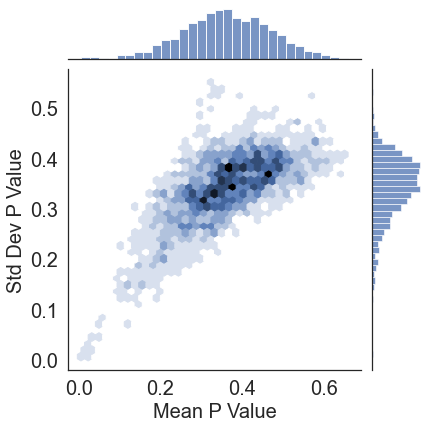

In [15]:

sns.set(rc={'xtick.labelsize':20,
            'ytick.labelsize':20}, style = "white")
g = (sns.jointplot("Mean_P_value","Standard_Deviation_P_value",data = df_fdr_pvals_2, kind="hex", bins = 10)
        .set_axis_labels("Mean P Value", "Std Dev P Value", fontsize=20))

plt.show()
g.savefig("png_files/Figure3C_Pvalue_atleast2_cancers.png", dpi = 300)

/Users/Lindsey/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


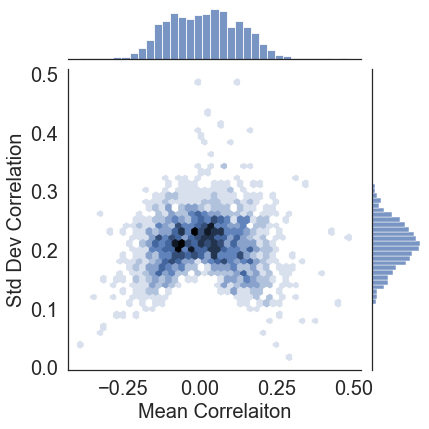

In [16]:
sns.set(rc={'xtick.labelsize':20,
            'ytick.labelsize':20}, style = "white")

g = (sns.jointplot("Mean_Correlation","Standard_Deviation_Correlation",data = df_fdr_pvals_2, kind="hex", bins = 10)
        .set_axis_labels("Mean Correlaiton", "Std Dev Correlation", fontsize=20))


g.savefig("png_files/Figure3C_Corr_atleast2_cancers.png", dpi = 300)
plt.show()

# At least 3 Cancers

In [17]:

df_fdr_pvals_3 = df_fdr_pvals[df_fdr_pvals['Num_sig'].isin([3,4,5,6,7,8])]

/Users/Lindsey/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


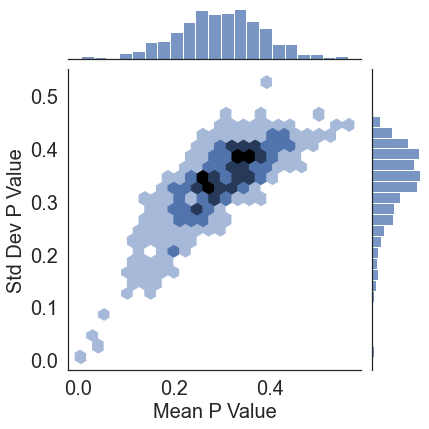

In [18]:

sns.set(rc={'xtick.labelsize':20,
            'ytick.labelsize':20}, style = "white")
g = (sns.jointplot("Mean_P_value","Standard_Deviation_P_value",data = df_fdr_pvals_3, kind="hex", bins = 5)
        .set_axis_labels("Mean P Value", "Std Dev P Value", fontsize=20))

plt.show()
g.savefig("png_files/Figure3C_Pvalue_atleast3_cancers.png", dpi = 300)

/Users/Lindsey/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


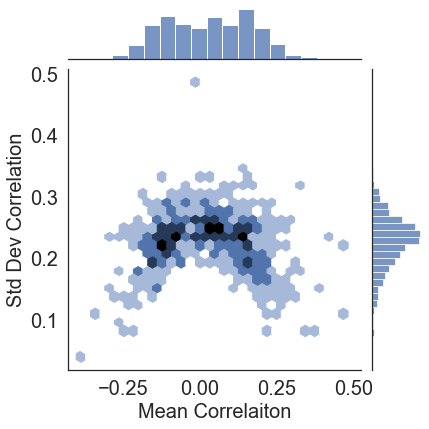

In [19]:
sns.set(rc={'xtick.labelsize':20,
            'ytick.labelsize':20}, style = "white")

g = (sns.jointplot("Mean_Correlation","Standard_Deviation_Correlation",data = df_fdr_pvals_3, kind="hex", bins = 5)
        .set_axis_labels("Mean Correlaiton", "Std Dev Correlation", fontsize=20))


g.savefig("png_files/Figure3C_Corr_atleast3_cancers.png", dpi = 300)
plt.show()